In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")
include("polyagamma.jl")

PG (generic function with 1 method)

#### Load data:

In [10]:
d, Nobs = 20_000, 22_000
X = sprandn(d, Nobs, 5e-2)
X[1,:] = ones(Nobs)
nz = 100
ξ_true = spzeros(d)
ξ_true[1] = 3*rand()
nzind = sample(1:d, nz)
ξ_true[nzind[1:Int(nz/2)]] = rand(Uniform(5,10),Int(nz/2))
ξ_true[nzind[Int(nz/2)+1:end]] = -rand(Uniform(5,10),Int(nz/2));
y = [rand(Binomial(1, 1/(1+exp(-X[:,n]'ξ_true)))) for n in 1:Nobs];

In [11]:
xxt = X*X'
100*sum(xxt .== 0.)/prod(size(xxt))

0.0

In [12]:
xxt = nothing 
gc()

#### Define prior:

In [14]:
σ02 = 1
prior = SS_prior(d, σ02);

#### Define model:

In [15]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);

#### Define minibatch sampler:

In [6]:
mb_size = 120
prob_het = 0.98
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)

@showprogress for i in 2:d 
    weights_het = abs.(X[i,:])./sum(abs.(X[i,:]))
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het, prob_het)
end
gs_list = mbsampler_list(d,gs);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


#### Define output scheduler:

In [15]:
A_xi = eye(d)
A_hyp = eye(1,hyperparam_size(prior))/hyperparam_size(prior)

opf = projopf(A_xi, A_hyp, 1000)
opt = maxa_opt(3*10^6, 10^6)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

#### Define mbsampler + block Gibbs sampler list:

In [16]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(2e2)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [17]:
ZZ_block_sample(my_model, outp, blocksampler, mstate);

10% attempts in 3.13 mins 
20% attempts in 6.24 mins 
30% attempts in 9.17 mins 
Trimmed after 1000000 bouncing attempts 
40% attempts in 12.05 mins 
50% attempts in 15.03 mins 
60% attempts in 18.19 mins 
70% attempts in 21.24 mins 
80% attempts in 24.21 mins 
90% attempts in 27.2 mins 
100% attempts in 30.05 mins 


In [18]:
print(maximum(abs.(outp.opf.xi_mu - mstate.mu)), "\n")
print(maximum(abs.(outp.opf.xi_m2 - mstate.m2)))

1.6954536272722924
19.082187818907215

* Number of bounces:

In [19]:
zz_bounces = sum(mstate.n_bounces)
hyp_bounces = outp.opf.tot_bounces-sum(mstate.n_bounces)
@printf("ZZ total bounces: %i, hyper bounces: %i", zz_bounces, hyp_bounces)

ZZ total bounces: 106398, hyper bounces: 5780

In [20]:
size(outp.opf.xi_skeleton,2)/outp.opt.max_attempts

0.020354

### Credible intervals:

In [21]:
nsamples = 10^4
xi_samples_gzz = extract_samples(outp.opf.xi_skeleton, 
                                 outp.opf.bt_skeleton, 
                                 outp.opf.bt_skeleton[end]/nsamples,
                                 "linear")
ci_gzz = zeros(d,2)
for i in 1:d 
    ci_gzz[i,:] = percentile(xi_samples_gzz[i,:], [5,95])
end

### Polya-Gamma:

In [22]:
xi_samples_pg = PG(my_model, rand(d), 10^4);

Progress: 100%|█████████████████████████████████████████| Time: 0:35:07


In [23]:
ci_pg = zeros(d,2)
for i in 1:d 
    ci_pg[i,:] = percentile(xi_samples_pg[1][i,:], [5,95])
end

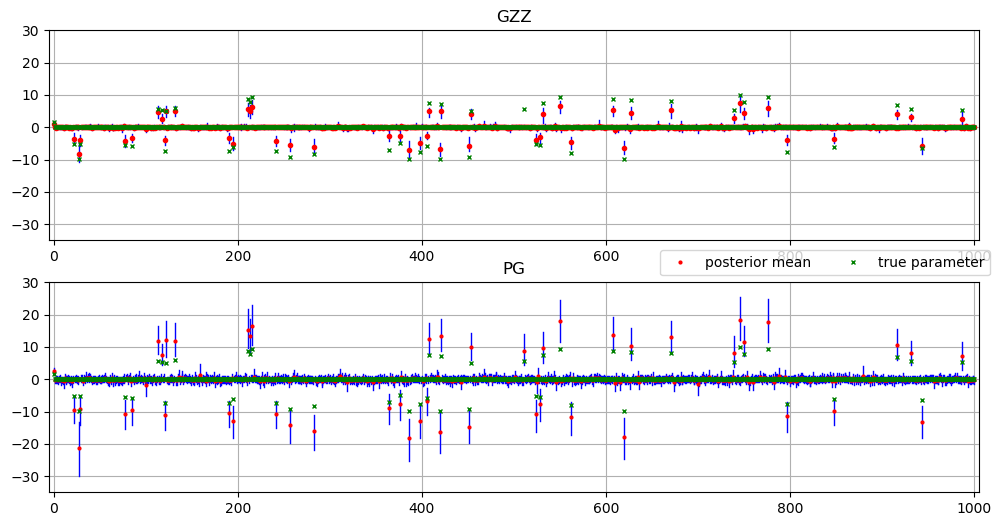

PyObject <matplotlib.legend.Legend object at 0x7f9f85ab7e10>

In [33]:
ymin, ymax = -35, 30
fig = figure(figsize=(12,6))
subplot(211)
for i in 1:d
    plot([i,i], ci_gzz[i,:], "b-", lw=1)
end
plot(1:d, outp.opf.xi_mu, "ro", markersize=3, label="posterior mean");
plot(1:d, ξ_true, "gx", markersize=3, label="true parameter")
grid(true)
title("GZZ")
ylim(ymin, ymax)
xlim(-5,d+5)

subplot(212)
for i in 1:d
    plot([i,i], ci_pg[i,:], "b-", lw=1)
end
plot(1:d, mean(xi_samples_pg[1],2), "ro", markersize=2, label="posterior mean");
plot(1:d, ξ_true, "gx", markersize=3, label="true parameter")
grid(true)
title("PG")
ylim(ymin, ymax)
xlim(-5,d+5)

legend(ncol=2,bbox_to_anchor=(0.65, 1))

In [32]:
maxlag = 200
acfs_gzz = zeros(d, maxlag)
acfs_pg = zeros(d, maxlag)

@showprogress for i in 1:d 
    acfs_gzz[i,:] = acf(xi_samples_gzz[i,:], maxlag)
    acfs_pg[i,:] = acf(xi_samples_pg[1][i,:], maxlag)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


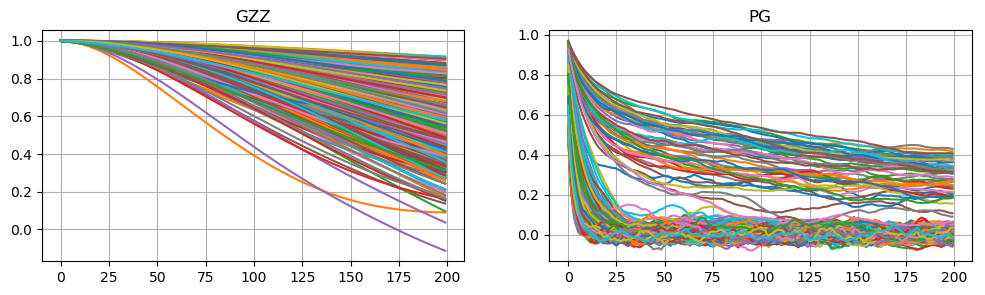

In [34]:
fig = figure("pyplot_subplot_mixed", figsize=(12,3))
subplot(121)
for i in 1:d 
    plot(acfs_gzz[i,:])
end
grid(true)
title("GZZ")

subplot(122)
for i in 1:d
    plot(acfs_pg[i,:])
end
grid(true)
title("PG");

In [ ]:
a = PG(my_model, zeros(size(X,1)), 10);

In [50]:
d = 1000
@printf("Space required to store %i by %i float matrix = %f GB", d, d, d*d*8/(2^12))

Space required to store 1000 by 1000 float matrix = 1953.125000 GB